<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [4]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz");
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz");
        print("done")
        assert os.path.exists(images_name);

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name);
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes";

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [335]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset();


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

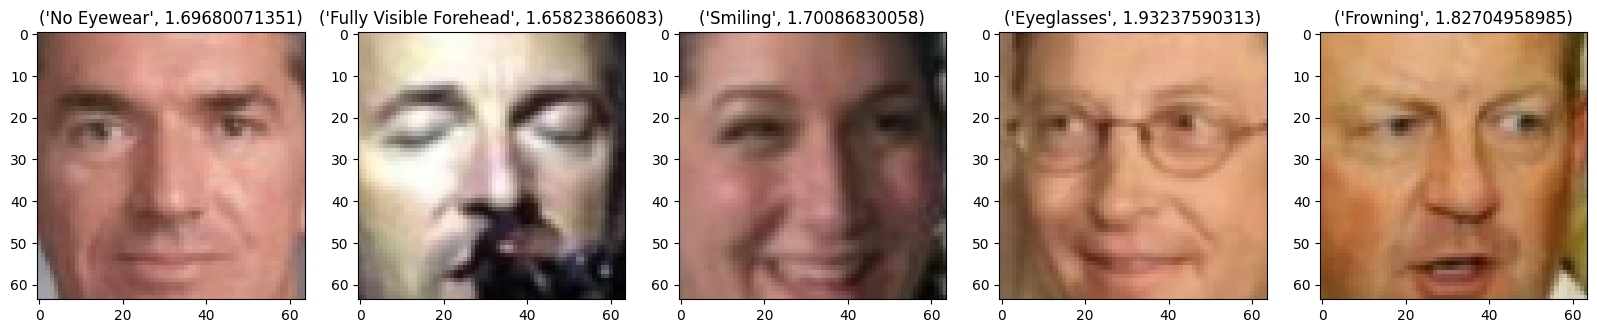

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random

data_tensor = torch.from_numpy(data).float().permute(0, 3, 1, 2)

train_data, val_data, train_attrs, val_attrs = train_test_split( data_tensor, attrs, test_size=0.3, shuffle=True)

train_loader = DataLoader(train_data, batch_size=32, drop_last=True)
val_loader = DataLoader(val_data, batch_size=32, drop_last=True)

plt.subplots(figsize=(20, 12));
for i in range(0, 5):
    index = random.randint(10, 4000)
    plt.subplot(2, 5, i+1);
    plt.imshow(data[index, :, :, :]);
    plt.title( [(k , v) for k, v in sorted(dict(attrs.iloc[index]).items(), key=lambda item: item[1], reverse=True)][1] );

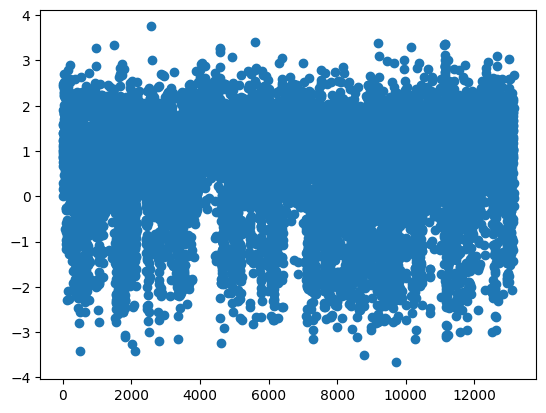

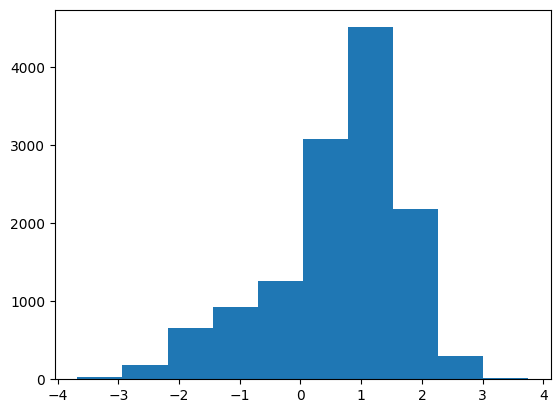

In [5]:
# На примере мужчин, можно заметить,что фотографии распределены равномерно, т.е номер фотографии не влияет на пол изображенного человека
plt.scatter( np.arange(len(attrs['Male'])) , attrs['Male'])
plt.show()

# Оценка 'male' для фотографии распределены нормально с мат ожиданием 1, значит мы ожидаем увидеть мужчин
plt.hist(attrs['Male']);

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [2]:
latent_dim = 16

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device

'cuda:0'

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.flatten = nn.Flatten(0)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, input_dim)
        )
    def forward(self, x):
        shape = x.shape

        x = self.flatten(x).float()
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code).view(*shape)
        return (reconstruction, latent_code)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [18]:
def train(model, loss_fn, optimizer, n_epochs, train_data, val_data, scheduler):
    train_losses = []
    val_losses = []

    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_loss_epoch = []
        print('train start')
        for i, X_batch in tqdm_notebook(enumerate(train_data)):
            optimizer.zero_grad()
            reconstructed, latent_code = model(X_batch.to(device))
            loss = loss_fn(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())
        train_losses.append(np.mean(train_loss_epoch))

        model.eval()
        val_loss_epoch = []
        with torch.no_grad():
            print('val start')
            for i, X_batch in tqdm_notebook(enumerate(val_data)):
                reconstructed, latent_code = model(X_batch.to(device))
                loss = loss_fn(reconstructed, X_batch.to(device))
                val_loss_epoch.append(loss.item())
                if (i == epoch):
                    plt.subplots(figsize=(20, 20));
                    plt.subplot(7, 7, 1);
                    plt.imshow(reconstructed.permute(1, 2, 0).detach().cpu(), label='val');
                    plt.subplot(7, 7, 3);
                    plt.imshow(X_batch.permute(1, 2, 0), label='real');
                    #plt.legend();
                    plt.show()
        scheduler.step()
        val_losses.append(np.mean(val_loss_epoch))
        print('epoch', epoch + 1, 'val' , val_losses[-1], 'train', train_losses[-1])

    return train_losses, val_losses

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [20]:
criterion = F.mse_loss

latent_dim = 16
input_dim = 64*64*3
autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder = autoencoder.to(device)

max_epochs = 18
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  0%|          | 0/18 [00:00<?, ?it/s]

train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

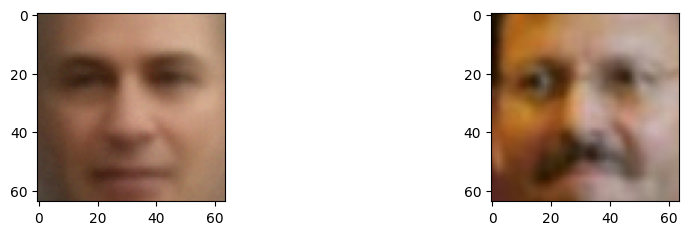

epoch 1 val 0.014165512762239594 train 0.01890819262983986
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

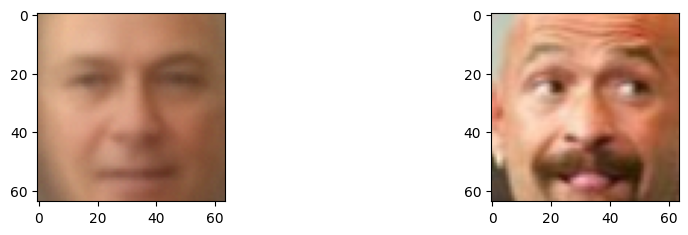

epoch 2 val 0.01081146125992533 train 0.01290033452916364
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

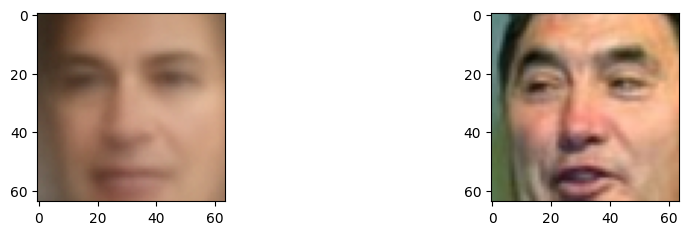

epoch 3 val 0.010306873485918841 train 0.01179547717063384
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

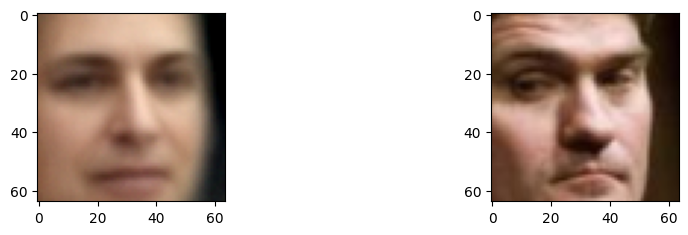

epoch 4 val 0.010113913563453087 train 0.011227014237539032
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

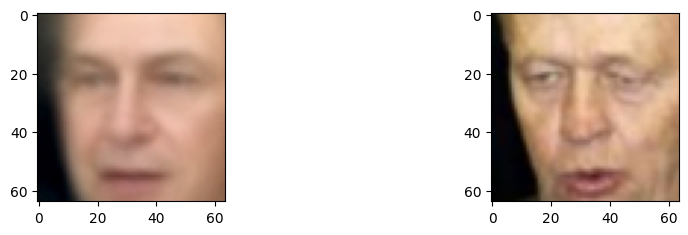

epoch 5 val 0.009141814752134433 train 0.010723280812886989
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

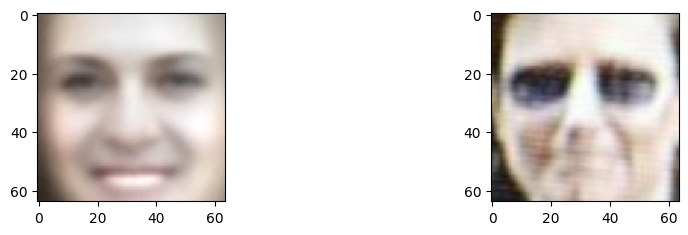

epoch 6 val 0.00884960632655045 train 0.009800631590048358
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

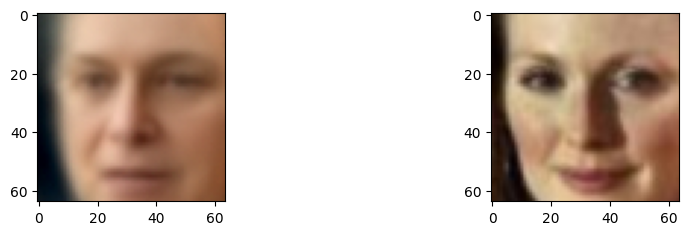

epoch 7 val 0.008716484845133847 train 0.00967763699993552
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

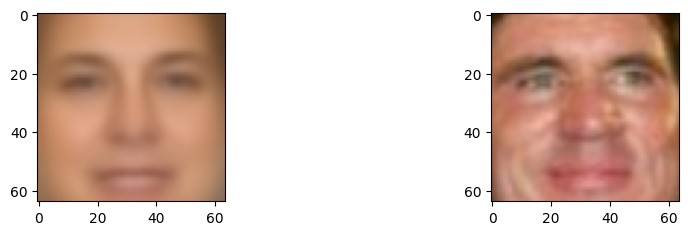

epoch 8 val 0.008614945441980227 train 0.009605750886485506
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

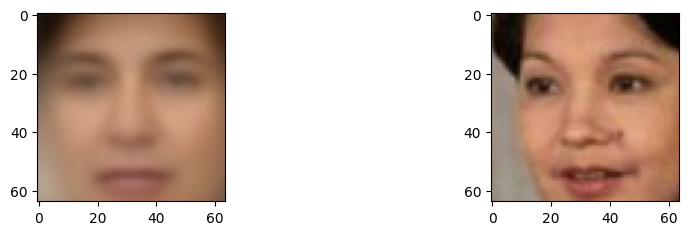

epoch 9 val 0.008639441402390459 train 0.009548051057018987
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

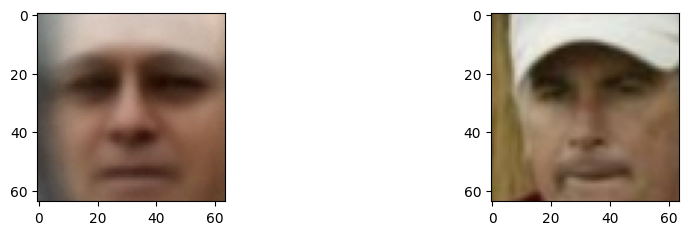

epoch 10 val 0.00859155752316411 train 0.009500999100210206
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

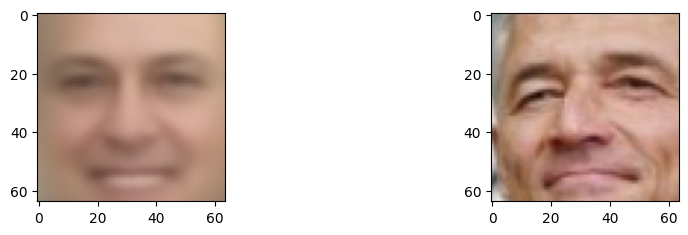

epoch 11 val 0.008600813653409829 train 0.009442707732896847
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

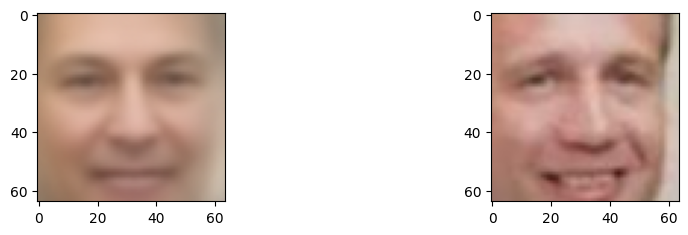

epoch 12 val 0.008557316740561913 train 0.009424106985844328
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

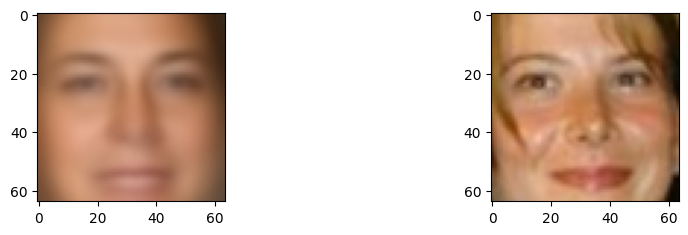

epoch 13 val 0.008578169259856588 train 0.00943381004556811
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

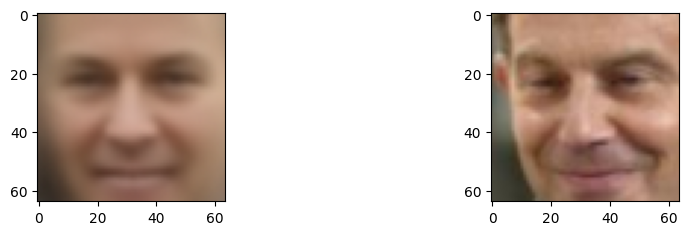

epoch 14 val 0.008552783659078047 train 0.009409232939259432
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

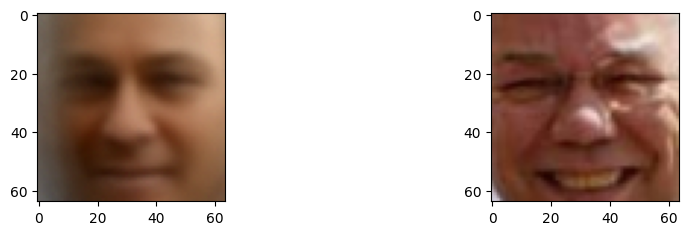

epoch 15 val 0.008571853588494412 train 0.00942724497411805
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

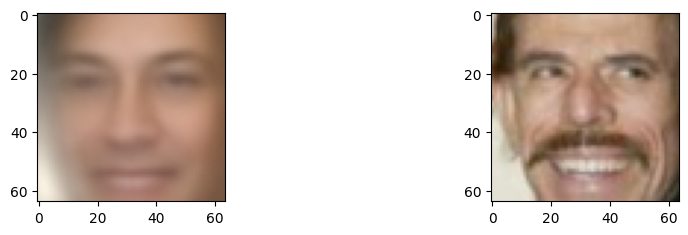

epoch 16 val 0.0085494945434801 train 0.00940588180308544
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

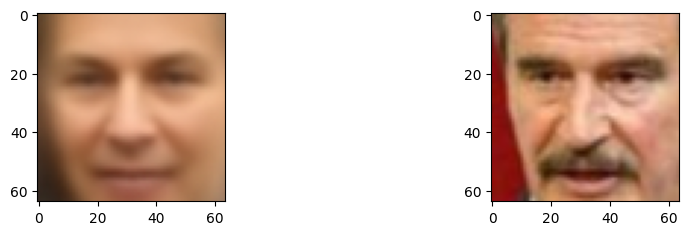

epoch 17 val 0.008546103636574518 train 0.009405740721267647
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

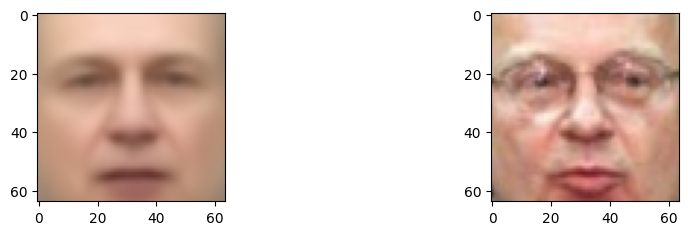

epoch 18 val 0.008552182938420784 train 0.009396133365327209


In [21]:
tr, val = train(autoencoder, criterion, optimizer, max_epochs, train_data, val_data, scheduler)

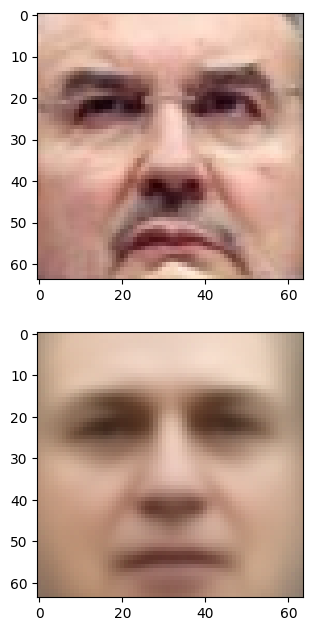

In [22]:
i = 9999
f1, f2 = autoencoder(data_tensor[i].to(device))
criterion(f1, data_tensor[i].to(device))
plt.subplots(figsize=(20, 20))
plt.subplot(5, 2, 1)
plt.imshow(data_tensor[i].permute(1, 2, 0))
plt.subplot(5, 2, 3)
plt.imshow(f1.permute(1, 2, 0).detach().cpu())

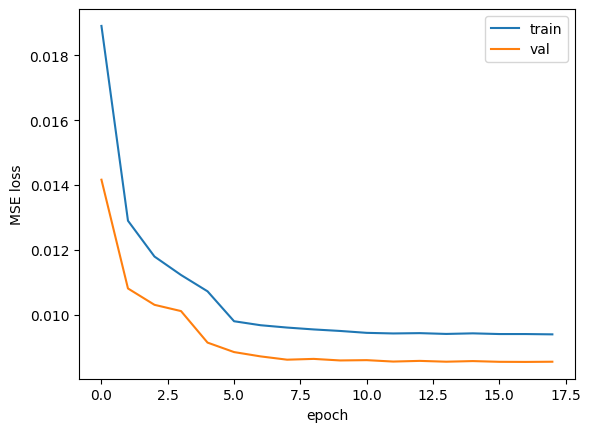

In [23]:
# Как мы видим, функция потерь на валидационной выборке меньше за счет более простого набора. Сходимость достигается на 10 эпохе.
plt.plot(np.arange(max_epochs),  tr, label='train')
plt.plot(np.arange(max_epochs), val, label='val')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

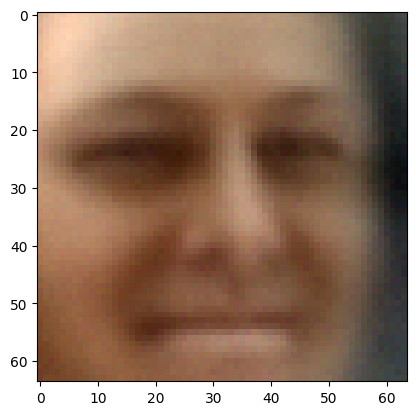

In [69]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.empty(25, latent_dim).normal_(0, 1)
z =  autoencoder.decoder(z.to(device)[1])
res = z.detach().cpu().view(3, 64, 64).permute(1, 2, 0)
res = torch.abs(res / torch.max(res))
plt.imshow(res)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [70]:
index_smil = attrs['Smiling']
index_frown =   attrs['Frowning']

# Отсортируем
index_smil = list({k: v for k, v in sorted(index_smil.items(), key=lambda item: item[1], reverse=True)})[:20]
index_frown = list({k: v for k, v in sorted(index_frown.items(), key=lambda item: item[1], reverse=True)})[:20]

In [71]:
# vector - вектор смещения

sm_vectors = torch.zeros(latent_dim)
fr_vectors = torch.zeros(latent_dim)

for sm, fr in zip(index_smil, index_frown):
    sm_vector = autoencoder.encoder(autoencoder.flatten(torch.tensor(data_tensor[sm]).to(device))).detach().cpu()
    fr_vector = autoencoder.encoder(autoencoder.flatten(torch.tensor(data_tensor[fr]).to(device))).detach().cpu()

    sm_vectors += sm_vector
    fr_vectors += fr_vector

mean_sm_vector =  sm_vectors / len(sm_vectors)
mean_fr_vector =  fr_vectors / len(fr_vectors)

vector = mean_sm_vector - mean_fr_vector

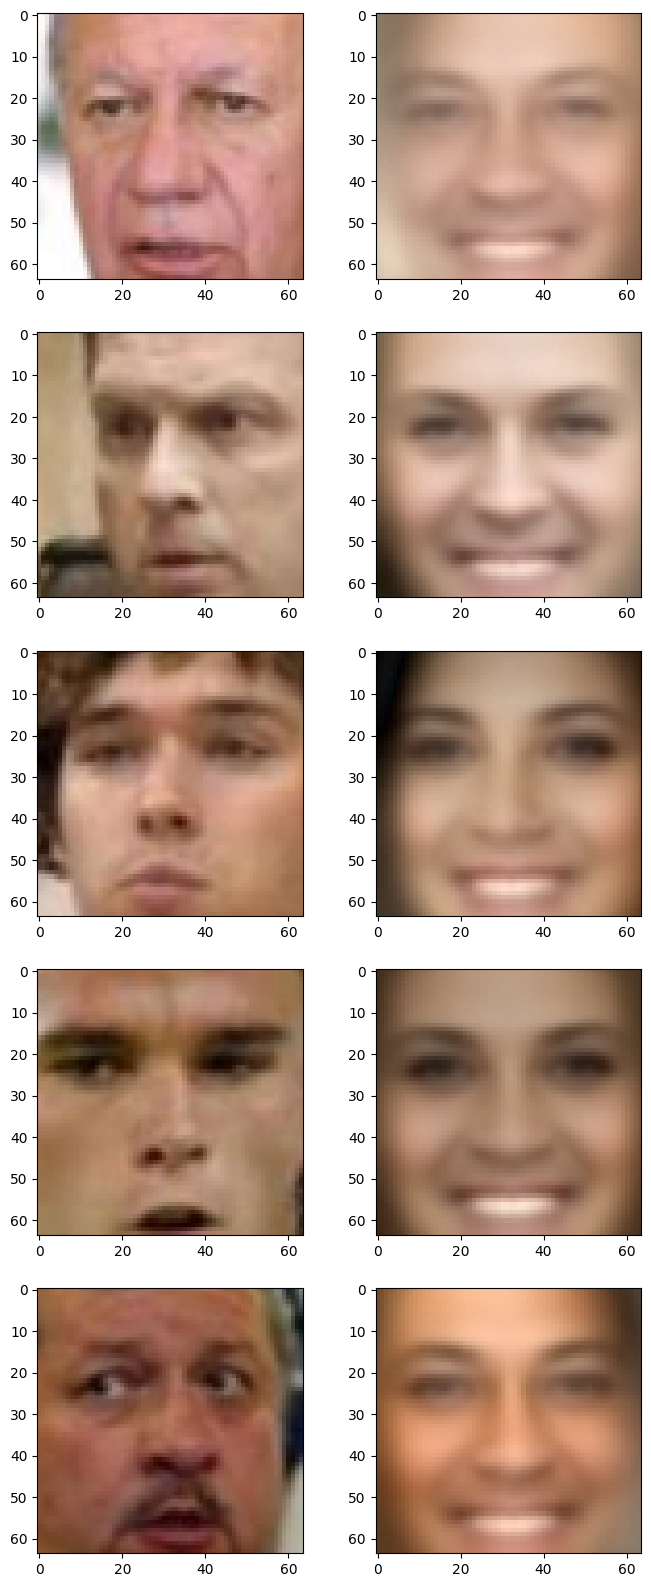

In [72]:
plt.figure(figsize=(8, 20))
for i in range(5):
    enc = autoencoder.encoder(autoencoder.flatten(data_tensor[index_frown[i]].to(device))).detach().cpu()
    dec_sm = autoencoder.decoder((enc + vector).to(device))
    res = dec_sm.detach().cpu().view(3, 64, 64).permute(1, 2, 0)

    res_sm = torch.abs(res / torch.max(res))
    res_fr = data_tensor[index_frown[i]].permute(1, 2, 0)

    plt.subplot(5, 2, 2*i+1)
    plt.imshow(res_fr)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res_sm)


Как мы видим на лицах появились улыбки, однако, в фотографиях изменилось не только выражение лица)
Из-за сильной связи между тем женщина привлекательна и тем, улыбается ли она.
Так, почти все привлекательные женщины имеют высокий индекс улыбки.

In [73]:
index_w = attrs['Attractive Woman']
index_w = list({k: v for k, v in sorted(index_w.items(), key=lambda item: item[1], reverse=True)})[:20]

for i in index_w:
    print(attrs['Smiling'][i])

1.75985594245
1.46222376948
2.09440682423
1.85107799816
1.15884255252
2.21659146052
2.32874373144
-0.700360038686
-0.4051564972
0.288959880509
2.11968326819
1.90854259486
2.45223593276
0.582189747847
-0.479280323731
1.99077802291
1.59305535172
1.85312116097
1.66667641258
-1.28136993625


# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [97]:
import torchvision.transforms as transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [75]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=latent_dim*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=input_dim)
        )


    def encode(self, x):
        mu, logsigma = torch.split(x, self.latent_dim, dim = 1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma, shapes):
        if self.training:
            z = torch.exp(logsigma)*torch.randn(shapes[0], self.latent_dim).to(device) + mu
            return z
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        shapes = x.shape
        x = self.flatten(x)
        x = self.encoder(x)
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma, shapes)
        reconstruction = self.decode(z).view(32, 1, 28, 28)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [30]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + 2*logsigma - mu.pow(2) - (logsigma.exp())**2)
    return loss

def log_likelihood(x, reconstruction):
    loss = -torch.sum(x*torch.log(torch.sigmoid(reconstruction)) + (1 - x )*torch.log(1 - torch.sigmoid(reconstruction)))
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [77]:
def train_vae(model, loss_fn, optimizer, n_epochs, train_data, val_data, scheduler):
    train_losses = []
    val_losses = []

    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_loss_epoch = []
        print('train start')
        for i, X_batch in tqdm_notebook(enumerate(train_data)):
            optimizer.zero_grad()
            X_batch = X_batch[0]
            mu, logsigma, reconstructed = model(X_batch.to(device))
            loss = loss_fn(X_batch.to(device), mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())
        train_losses.append(np.mean(train_loss_epoch))

        model.eval()
        val_loss_epoch = []
        with torch.no_grad():
            print('val start')
            for i, X_batch in tqdm_notebook(enumerate(val_data)):
                X_batch = X_batch[0]
                mu, logsigma, reconstructed = model(X_batch.to(device))
                loss = loss_fn(X_batch.to(device), mu, logsigma, reconstructed)
                val_loss_epoch.append(loss.item())
                if (i == epoch and epoch % 4 == 0):
                    plt.subplots(figsize=(20, 20));
                    plt.subplot(7, 7, 1);
                    plt.imshow(torch.sigmoid(reconstructed[1]).permute(1, 2, 0).detach().cpu(), label='val');
                    plt.subplot(7, 7, 3);
                    plt.imshow(X_batch[1].permute(1, 2, 0), label='real');
                    plt.show()
        scheduler.step()
        val_losses.append(np.mean(val_loss_epoch))
        print('epoch', epoch + 1, 'val' , val_losses[-1], 'train', train_losses[-1])

    return train_losses, val_losses

In [78]:
criterion = loss_vae

input_dim = 784
latent_dim = 8

autoencoder = VAE(input_dim, latent_dim).to(device)

max_epochs = 13
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  0%|          | 0/13 [00:00<?, ?it/s]

train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

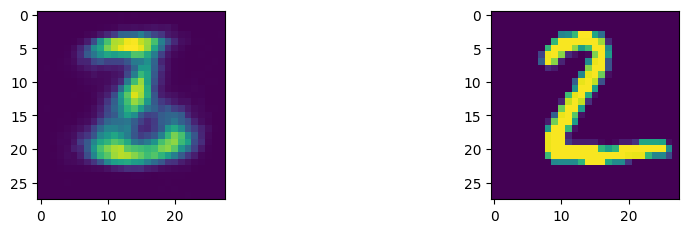

epoch 1 val 4633.037337083083 train 6227.656459114583
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 2 val 4182.346437111879 train 4539.537168619791
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 3 val 3996.4813780173276 train 4271.724293880208
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 4 val 3890.270075871394 train 4140.689447916667
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

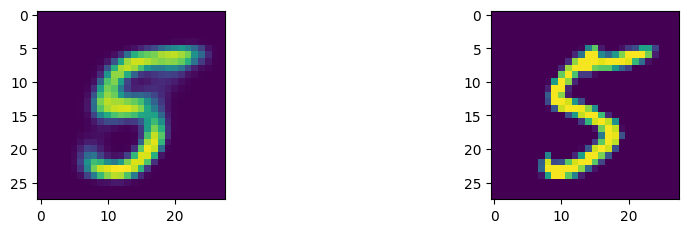

epoch 5 val 3826.560390374599 train 4062.4488415364585
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 6 val 3814.686273819361 train 4021.140283203125
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 7 val 3813.5138964530747 train 4015.0222134114583
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 8 val 3807.4090091020635 train 4009.94977109375
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

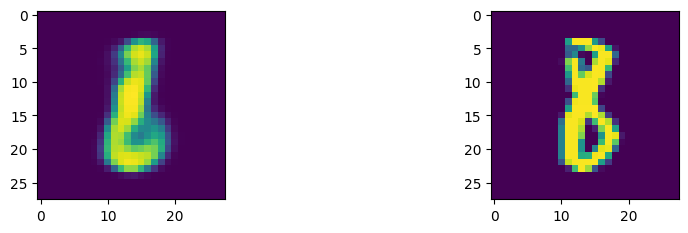

epoch 9 val 3805.0293978177583 train 4005.93807734375
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 10 val 3797.263433994391 train 4000.3075313802083
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 11 val 3798.0503774789663 train 3997.2970375
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 12 val 3797.334188608023 train 3996.839334765625
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

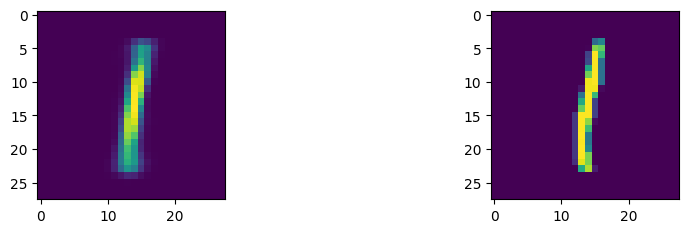

epoch 13 val 3796.2500939002402 train 3995.1534875


In [79]:
tr, val = train_vae(autoencoder, criterion, optimizer, max_epochs, train_loader, test_loader, scheduler)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

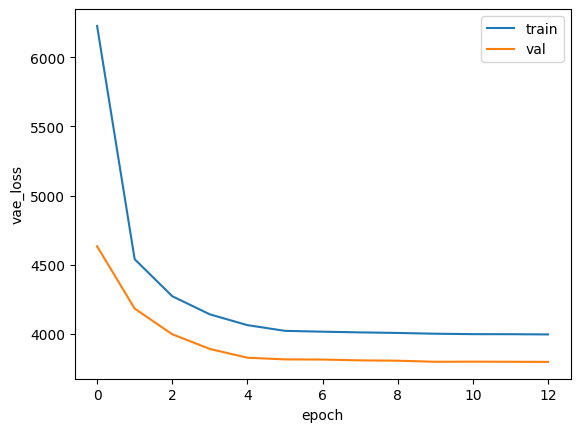

In [80]:
plt.plot(np.arange(max_epochs),  tr, label='train')
plt.plot(np.arange(max_epochs), val, label='val')
plt.xlabel('epoch')
plt.ylabel('vae_loss')
plt.legend()
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

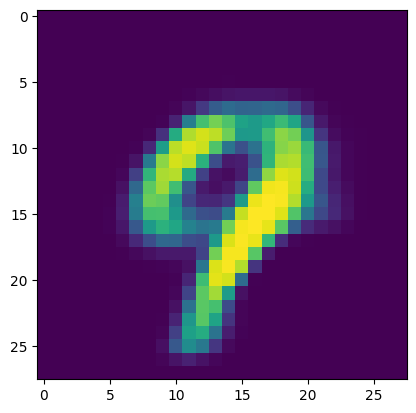

In [84]:
z = torch.empty(250, latent_dim).normal_(0, 1)
autoencoder.eval()
z =  torch.sigmoid(autoencoder.decoder(z.to(device)[1]))
res = z.detach().cpu().view(1, 28, 28).permute(1, 2, 0)
plt.imshow(res)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [7]:
from sklearn.manifold import TSNE

In [337]:
embed = TSNE(
    n_components=2,
    perplexity=10, 
    learning_rate=200, 
    n_iter=2000, 
    random_state=42)   

In [338]:
res = torch.zeros(32, 8)
classes = torch.zeros(32)
for i, (X_batch, Y_batch) in enumerate(test_loader):
    x = autoencoder.flatten(X_batch.to(device))
    x = autoencoder.encoder(x)
    m, logsigma = autoencoder.encode(x)
    m = m.detach().cpu().numpy()
    res = np.concatenate((res, m), axis=0)
    classes = np.concatenate((classes, Y_batch), axis=0)
    
res = res[32:]
embeded = embed.fit_transform(res)

In [377]:
classes_n = classes[32:].astype('int')

array([7, 2, 1, ..., 6, 5, 0])

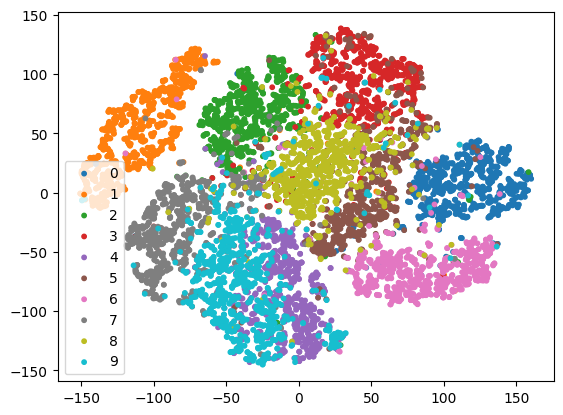

In [340]:
X, Y = embeded[:, 0], embeded[:, 1]

df = pd.DataFrame({'x': X,'y' : Y, 'classes_num' : classes_n})
groups = df.groupby('classes_num')
for name, group in groups:
    plt.scatter(group.x, group.y, marker='o', linestyle='', s=10, label=name);
plt.legend();

Как мы видим, классы неплохо разделяются. Например, 0 1 6 отделены. Классы 9 и 4 имеют близкое матожидание, это кажется интуитивно понятным - 4 и 9 имеют схожие структуры(замкнутую область и нижний хвост). Интересно посмотреть как изменятся распределения классов, если подать в t-SNE сразу, не пропуская через encoder.

In [440]:
embed_t = TSNE(
    n_components=2,
    perplexity=10, 
    learning_rate=200, 
    n_iter=2000, 
    random_state=42)   

nums = np.array([])
tensors = torch.zeros(1, 784)
for ten, num  in test_dataset:
    tensor_flat = autoencoder.flatten(ten)
    tensors = np.concatenate((tensors, tensor_flat), axis=0)
    nums = np.append(nums, num)

In [455]:
tensors_t = tensors[1:]
nums = nums.astype('int')

In [456]:
embeded_t = embed_t.fit_transform(tensors_t)

In [457]:
X, Y = embeded_t[:, 0], embeded_t[:, 1]

Как мы видим, классы разделяются лучше. Encoder и tsne используют примерно одну и ту же идею о сближении распределния в двух пространствах - в tsne используется распределение Стьюдента с более тяжелыми хвостами и по другому построенная функция потерь.В encoder, за счет vae_loss, мы стараемся минимизоровать не только дивергенцию, но и кросс энтропию,которая отвечает за схожесть изображений. Как мы знаем различные цифры могут быть схожи на изображении(9 и 4), что влияет на общий лосс, в отличии модели TSNE.

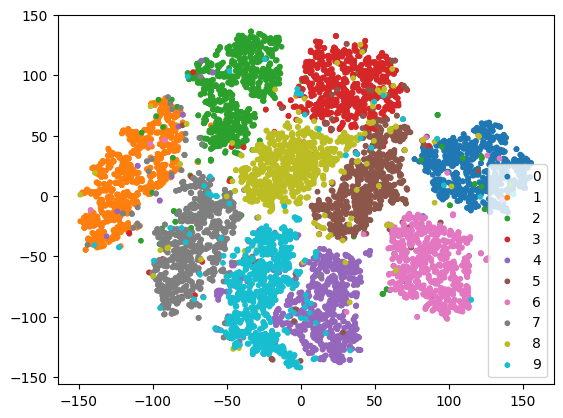

In [460]:
X, Y = embeded_t[:, 0], embeded_t[:, 1]

df = pd.DataFrame({'x': X,'y' : Y, 'classes_num' : nums})
groups = df.groupby('classes_num')
for name, group in groups:
    plt.scatter(group.x, group.y, marker='o', linestyle='', s=10, label=name);
plt.legend();

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [340]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim + 10, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=128, out_features=latent_dim*2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim + 10, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=512, out_features=input_dim)
        )


    def encode(self, x):
        mu, logsigma = torch.split(x, self.latent_dim, dim = 1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma, shapes):
        if self.training:
            z = torch.exp(logsigma)*torch.randn(shapes[0], self.latent_dim).to(device) + mu
            return z
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction
    
    def concat(self, z, class_num):
        res = torch.cat((z, class_num), 1)
        return res

    def forward(self, x, class_num):
        shapes = x.shape
        x = self.flatten(x)
        x = self.concat(x, class_num)
        x = self.encoder(x)
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma, shapes)
        z = self.concat(z, class_num)
        reconstruction = self.decode(z).view(32, 1, 28, 28)
        return mu, logsigma, reconstruction

In [341]:
def train_cvae(model, loss_fn, optimizer, n_epochs, train_data, val_data, scheduler):
    train_losses = []
    val_losses = []

    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_loss_epoch = []
        print('train start')
        for i, (X_batch, Y_batch) in tqdm_notebook(enumerate(train_data)):
            optimizer.zero_grad()
            Y_batch = Y_batch.to(device)
            z = F.one_hot(Y_batch % 10, num_classes=10)
            mu, logsigma, reconstructed = model(X_batch.to(device), z)
            #loss = loss_fn(X_batch.to(device), mu, logsigma, reconstructed)
            loss = loss_fn(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())
        train_losses.append(np.mean(train_loss_epoch))

        model.eval()
        val_loss_epoch = []
        with torch.no_grad():
            print('val start')
            for i, (X_batch, Y_batch) in tqdm_notebook(enumerate(val_data)):
                X_batch = X_batch
                Y_batch = Y_batch.to(device)
                z = F.one_hot(Y_batch % 10, num_classes=10)
                mu, logsigma, reconstructed = model(X_batch.to(device), z)
                #loss = loss_fn(X_batch.to(device), mu, logsigma, reconstructed)
                loss = loss_fn(reconstructed, X_batch.to(device))
                val_loss_epoch.append(loss.item())
                if (i == epoch and epoch % 4 == 0):
                    print('num = ', Y_batch[1].item())
                    plt.subplots(figsize=(20, 20));
                    plt.subplot(7, 7, 1);
                    plt.imshow(torch.sigmoid(reconstructed[1]).permute(1, 2, 0).detach().cpu(), label='val');
                    plt.subplot(7, 7, 3);
                    plt.imshow(X_batch[1].permute(1, 2, 0), label='real');
                    plt.show()
        scheduler.step()
        val_losses.append(np.mean(val_loss_epoch))
        print('epoch', epoch + 1, 'val' , val_losses[-1], 'train', train_losses[-1])

    return train_losses, val_losses

In [342]:
#criterion = loss_vae
criterion = F.mse_loss
input_dim = 784
latent_dim = 8

model = CVAE(input_dim, latent_dim).to(device)

max_epochs = 18
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

  0%|          | 0/18 [00:00<?, ?it/s]

train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

num =  2


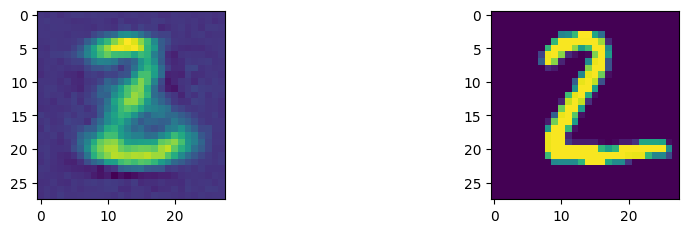

epoch 1 val 0.030414097882711735 train 0.04529515835344791
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 2 val 0.026250591818004463 train 0.031200888666510582
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 3 val 0.02430566168652895 train 0.028395353997747102
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 4 val 0.023227982378254335 train 0.02699809020658334
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

num =  5


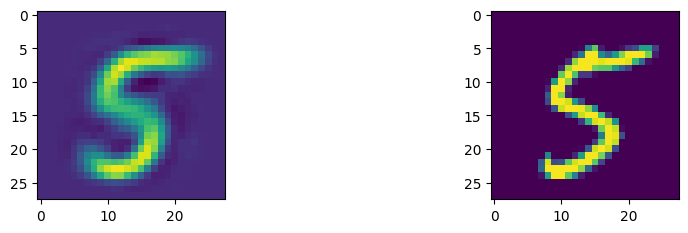

epoch 5 val 0.02293523895339324 train 0.026232988234361012
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 6 val 0.022815359929480996 train 0.026125386708974838
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 7 val 0.02270020625124184 train 0.02602806267340978
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 8 val 0.02263576032904287 train 0.025942472037672998
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

num =  8


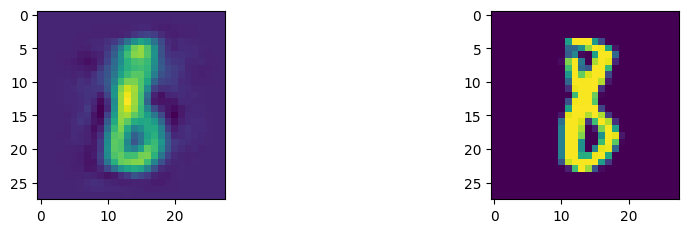

epoch 9 val 0.022605141911369104 train 0.025874230812986693
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 10 val 0.02260435153491413 train 0.025866939424475033
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 11 val 0.022589953028214857 train 0.02585272065301736
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 12 val 0.022583399618713137 train 0.02583743851184845
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

num =  1


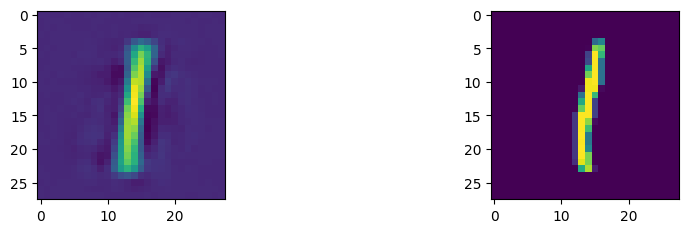

epoch 13 val 0.022580853887260534 train 0.025846649889151255
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 14 val 0.022580986173871238 train 0.02582477094431718
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 15 val 0.022580393378097467 train 0.025826938317219415
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 16 val 0.022579108230554715 train 0.025835284278790158
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

num =  2


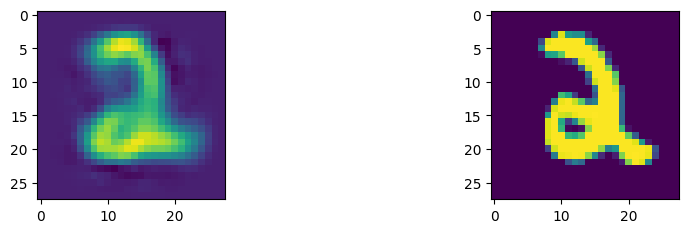

epoch 17 val 0.022579407731357675 train 0.025825462898612022
train start


0it [00:00, ?it/s]

val start


0it [00:00, ?it/s]

epoch 18 val 0.022579211777505968 train 0.02579713013569514


In [343]:
tr, val = train_cvae(model, criterion, optimizer, max_epochs, train_loader, test_loader, scheduler)

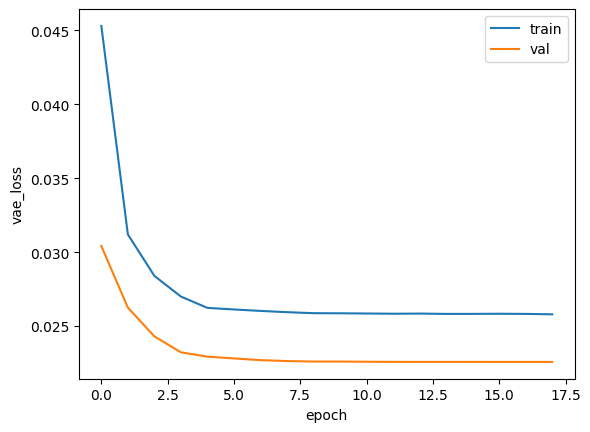

In [344]:
plt.plot(np.arange(max_epochs),  tr, label='train')
plt.plot(np.arange(max_epochs), val, label='val')
plt.xlabel('epoch')
plt.ylabel('vae_loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

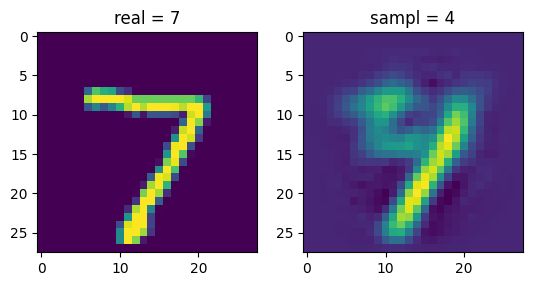

In [345]:
z = torch.empty(1, latent_dim).normal_(0, 1).to(device)
model.eval()
num = torch.zeros(1, 10).to(device)
num[0][1] = 1

for (x, y) in test_loader:
    X = x.to(device)
    Y = y.to(device)
    break
    
shapes = X.shape
def sampl(X, Y, num):
    nums = F.one_hot(Y % 10, num_classes=10)
    nums[0][7] = 0
    nums[0][num] = 1
    X_t = model.flatten(X)
    X_t = model.concat(X_t, nums)
    X_t = model.encoder(X_t)
    mu, logsigma = model.encode(X_t)
    z = model.gaussian_sampler(mu, logsigma, shapes)
    z = model.concat(z, nums)
    res = torch.sigmoid(model.decoder(z))[0]
    res = res.detach().cpu().view(1, 28, 28).permute(1, 2, 0)
    return res

res = sampl(X, Y, 4)
plt.subplots(figsize=(20, 20));
plt.subplot(6, 6, 1);
plt.title('real = 7')
plt.imshow(X[0].detach().cpu().view(1, 28, 28).permute(1, 2, 0))
plt.subplot(6, 6, 2);
plt.title('sampl = 4')
plt.imshow(res)
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [346]:
embed = TSNE(
    n_components=2,
    perplexity=10, 
    learning_rate=200, 
    n_iter=2000, 
    random_state=42)   

In [347]:
res = torch.zeros(32, 8)
classes = torch.zeros(32)
for i, (X_batch, Y_batch) in enumerate(test_loader):
    Y_batch = Y_batch.to(device)
    z = F.one_hot(Y_batch % 10, num_classes=10)
    x = model.flatten(X_batch.to(device))
    x = model.concat(x, z)
    x = model.encoder(x)
    m, logsigma = model.encode(x)
    m = m.detach().cpu().numpy()
    res = np.concatenate((res, m), axis=0)
    classes = np.concatenate((classes, Y_batch.detach().cpu()), axis=0)
    
res = res[32:]
embeded = embed.fit_transform(res)

In [348]:
classes_n = classes[32:].astype('int')

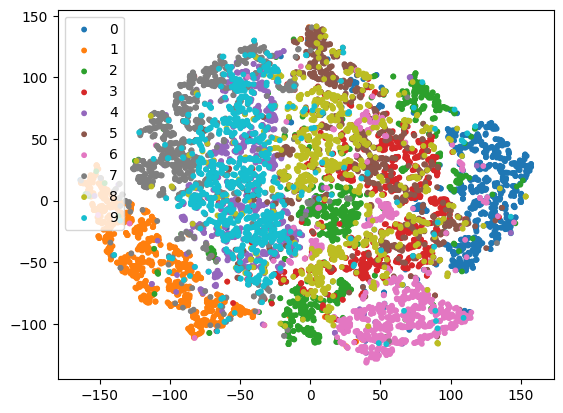

In [349]:
X, Y = embeded[:, 0], embeded[:, 1]

df = pd.DataFrame({'x': X,'y' : Y, 'classes_num' : classes_n})
groups = df.groupby('classes_num')
for name, group in groups:
    plt.scatter(group.x, group.y, marker='o', linestyle='', s=10, label=name);
plt.legend();

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>